<a href="https://colab.research.google.com/github/surajsarkar/deepLearning/blob/main/notebook/06_transfer_learning_tensorflow_part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **06 Tensorflow Scaling Up Tarnsfer Learning part:3**

### Getting the helper script

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-06-20 09:02:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-20 09:02:19 (61.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, unzip_data, walk_through_dir

### Get the Food101 10 percent data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2022-06-20 09:02:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   227MB/s    in 6.9s    

2022-06-20 09:02:40 (225 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# Unzip the data
unzip_data("101_food_classes_10_percent.zip")

In [ ]:
#Create Data Loaders 
import tensorflow as tf

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

# Create batch data generator 
train_data_10_percent_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 batch_size=32,
                                                                                 image_size=(224, 224))

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                batch_size=32,
                                                                image_size=(224, 224),
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


### Create a `ModelCheckpoint`

In [ ]:
checkpoint_path = "checkpoints/checkpoint"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_weights_only=True,
                                                      save_freq="epoch",
                                                      save_best_only=True,)

### Create Data Augmentaion

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Set up data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1/255.) # Not required for EfficientNet
], name="data_augmentation")

In [ ]:
# 1. Create a base_model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
# Set the trainable parameter to False
base_model.trainable = False

# 2. Create input layer
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="Input_layer")

# 3. Add augmentation model
aug_layer = data_augmentation(inputs)

# 4. Pass the augmentation layer to the base_model and set training to False.
x = base_model(aug_layer, training=False)

# Create a pooling layer and pass the base model to it.
x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)

# 5. Create a output layer
outputs = layers.Dense(101, activation="softmax", name="output_layer")(x)

# 6. Create model with input and output layer
model_0 = tf.keras.Model(inputs, outputs)


# 7. Compile the model 
# model_0.

16719872/16705208 [==============================] - 1s 0us/step


In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

### Compile the model

In [ ]:
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Fit the model


In [ ]:
history_0 = model_0.fit(
    train_data_10_percent_full,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent_full),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[model_checkpoint]
)

Epoch 1/5
237/237 [==============================] - 141s 522ms/step - loss: 3.4822 - accuracy: 0.2417 - val_loss: 2.4571 - val_accuracy: 0.4455
Epoch 2/5
237/237 [==============================] - 107s 450ms/step - loss: 2.3837 - accuracy: 0.4508 - val_loss: 2.0251 - val_accuracy: 0.5034
Epoch 3/5
237/237 [==============================] - 102s 430ms/step - loss: 2.0146 - accuracy: 0.5179 - val_loss: 1.8534 - val_accuracy: 0.5307
Epoch 4/5
237/237 [==============================] - 102s 428ms/step - loss: 1.7972 - accuracy: 0.5611 - val_loss: 1.7761 - val_accuracy: 0.5421
Epoch 5/5
237/237 [==============================] - 95s 401ms/step - loss: 1.6471 - accuracy: 0.5937 - val_loss: 1.7238 - val_accuracy: 0.5494


In [ ]:
# Evaluate the model 
model_0_evaluate = model_0.evaluate(test_data)

790/790 [==============================] - 60s 76ms/step - loss: 1.7238 - accuracy: 0.5494


In [ ]:
model_0_evaluate

[1.7237582206726074, 0.5494257211685181]

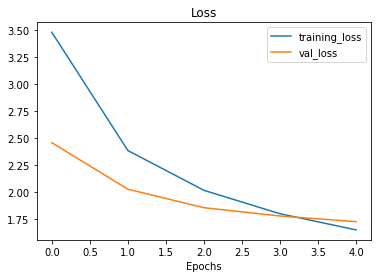

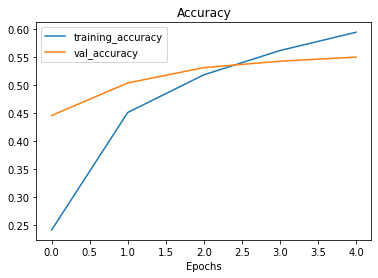

In [ ]:
# Visualise the loss curve
plot_loss_curves(history=history_0)

### Fine Tuning

In [ ]:
# Lets unfreez some of the layers of efficient net

# Lets unfreez all of the layer
base_model.trainable = True

# Refreez all of the layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False


In [ ]:
for layer_num, layer in enumerate(base_model.layers):
  print(layer_num, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

### Recompile model with lower learning rate.

In [ ]:
model_0.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

In [ ]:
for layer in model_0.layers:
  print(layer.name, layer.trainable)

Input_layer True
data_augmentation True
efficientnetb0 True
pooling_layer True
output_layer True


### Fitting the tuned model

In [ ]:
history_fine_tune = model_0.fit(
    train_data_10_percent_full,
    epochs=10,
    validation_data=test_data,
    validation_steps=(0.15 * len(test_data)),
    callbacks = [model_checkpoint],
    initial_epoch=history_0.epoch[-1]
)

Epoch 5/10
237/237 [==============================] - 57s 209ms/step - loss: 1.3929 - accuracy: 0.6467 - val_loss: 1.8380 - val_accuracy: 0.5171
Epoch 6/10
237/237 [==============================] - 45s 188ms/step - loss: 1.2762 - accuracy: 0.6673 - val_loss: 1.8319 - val_accuracy: 0.5218
Epoch 7/10
237/237 [==============================] - 45s 187ms/step - loss: 1.1975 - accuracy: 0.6836 - val_loss: 1.8411 - val_accuracy: 0.5192
Epoch 8/10
237/237 [==============================] - 41s 169ms/step - loss: 1.1427 - accuracy: 0.6954 - val_loss: 1.8411 - val_accuracy: 0.5239
Epoch 9/10
237/237 [==============================] - 41s 172ms/step - loss: 1.0698 - accuracy: 0.7185 - val_loss: 1.8310 - val_accuracy: 0.5221
Epoch 10/10
237/237 [==============================] - 40s 169ms/step - loss: 1.0319 - accuracy: 0.7237 - val_loss: 1.8139 - val_accuracy: 0.5312


In [ ]:
# Evaluate the tuned model on full test data
tuned_model_0_evaluation = model_0.evaluate(test_data)

790/790 [==============================] - 59s 74ms/step - loss: 1.6132 - accuracy: 0.5761


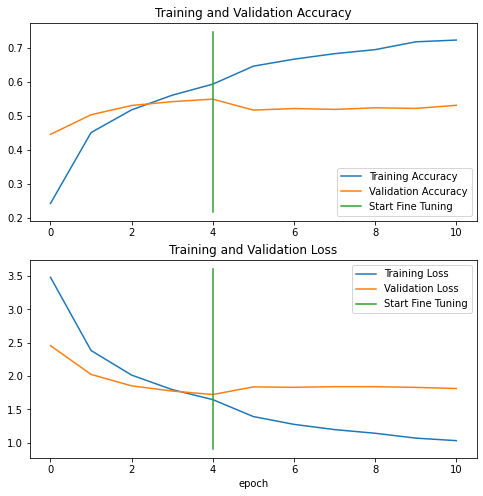

In [ ]:
from helper_functions import compare_historys
compare_historys(history_0, history_fine_tune)

## Save and load our model

In [ ]:
# Save our fine tune model
model_0.save("/content/drive/MyDrive/Colab Notebooks/tensorflow_course/models")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/tensorflow_course/models/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/tensorflow_course/models/assets


### Load our model 

In [ ]:
loded_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/tensorflow_course/models")

In [ ]:
# Evaluate the loaded models compare the result with pre-saved models
loaded_model_result = loded_model.evaluate(test_data)

790/790 [==============================] - 62s 76ms/step - loss: 1.6132 - accuracy: 0.5761


# Evaluate the performance the of the big dog model across all different classes

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-06-20 09:04:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  --.-KB/s    in 0.1s    

2022-06-20 09:04:15 (317 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
# Loading save model
d_model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model/")

In [ ]:
# Evaluate d_model
d_model_evaluation = d_model.evaluate(test_data)

790/790 [==============================] - 70s 73ms/step - loss: 1.8027 - accuracy: 0.6078


## Making prediction with our trained model

In [ ]:
pred_probs = d_model.predict(test_data, verbose=1)

790/790 [==============================] - 60s 74ms/step


In [ ]:
tf.argmax(tf.expand_dims(pred_probs[0, :], axis=0), axis=1)

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([52])>

In [ ]:
pred_probs[0].argmax()

52

In [ ]:
pred_probs[0][52]

0.84741855

In [ ]:
train_data_10_percent_full.class_names[52]

'gyoza'

In [ ]:
test_data.class_names[pred_probs[0].argmax()]

'gyoza'

In [ ]:
# Get the pred classes of each of the label 
pred_classes = pred_probs.argmax(axis=1)

# How do they look? 
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
len(pred_classes)

25250

In [ ]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [ ]:
# To get our test labels we need to unravel our test_data BatchDataSet

y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10] # Look at the first ten correct labels

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
y_labels[245:260]

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels, y_pred=pred_classes)

In [ ]:
sklearn_accuracy

0.6077623762376237

In [ ]:
# Does the accuracy even close to our evaluation?
import numpy as np
np.isclose(d_model_evaluation[1], sklearn_accuracy)

True

## Let's get visual: Make confusion metrics

In [ ]:
from helper_functions import make_confusion_matrix
import matplotlib.pyplot as plt

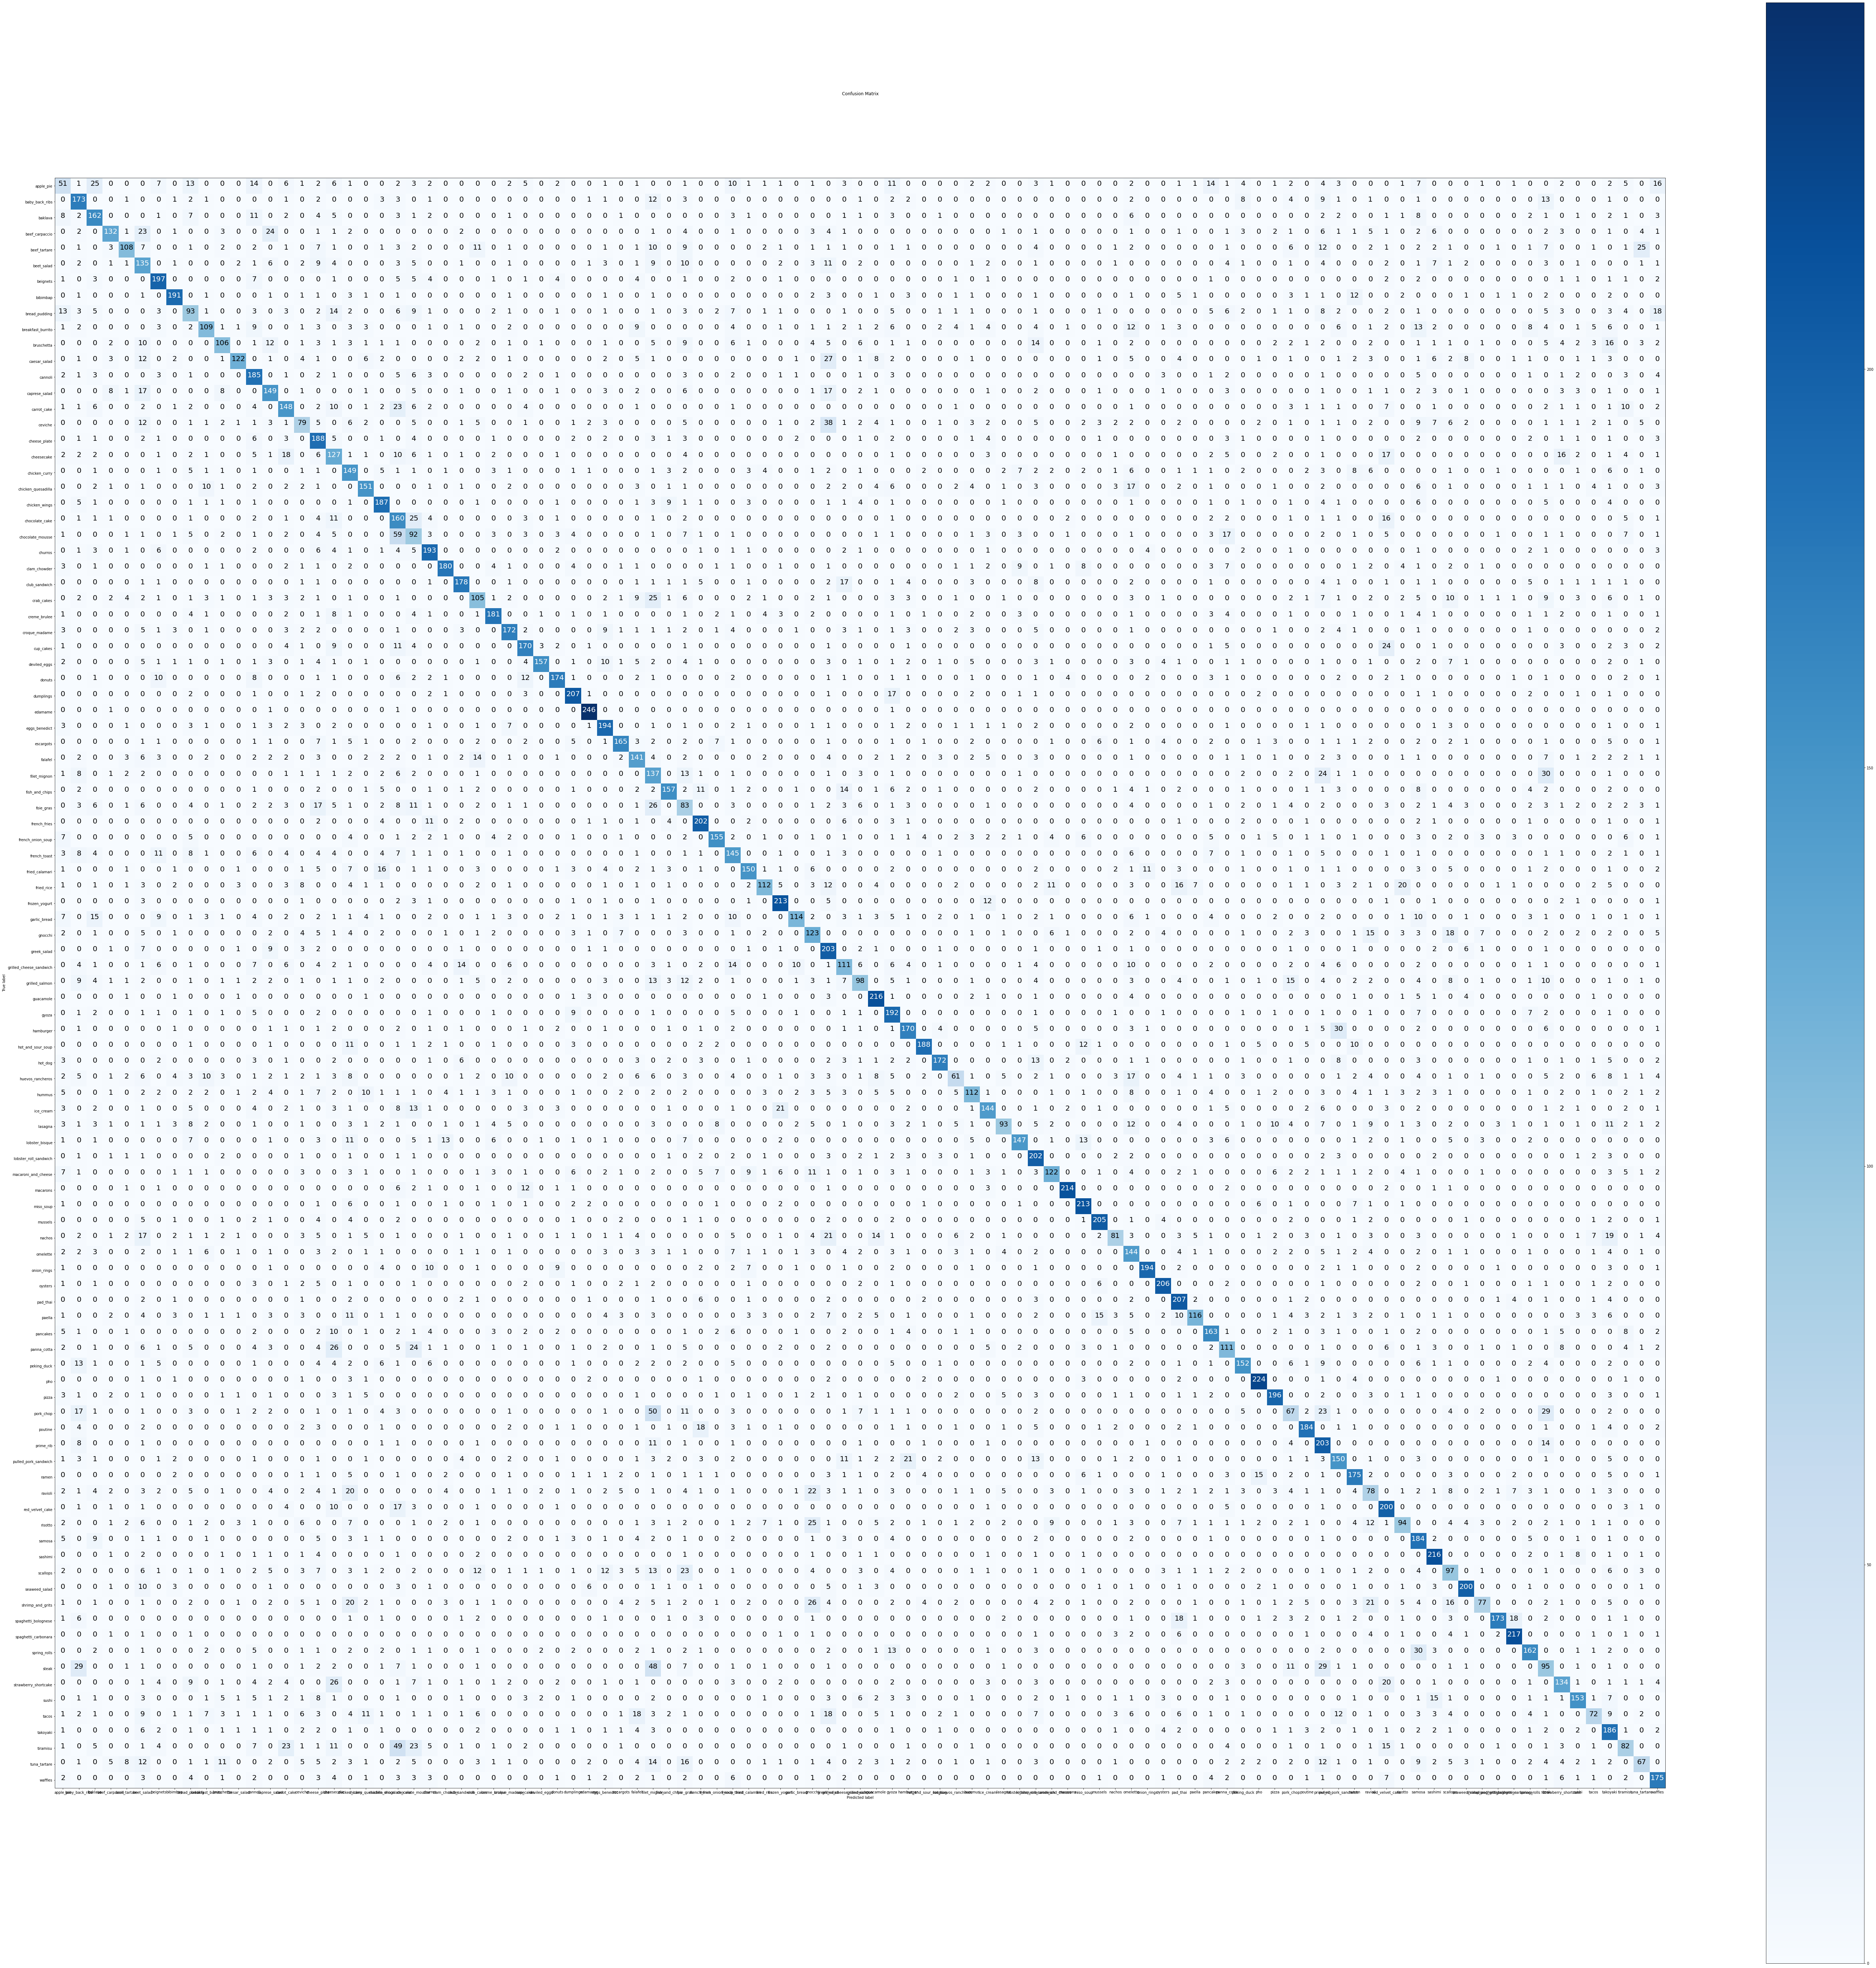

In [ ]:
make_confusion_matrix(y_true=y_labels, y_pred=pred_classes, classes=test_data.class_names, figsize=(100, 100), text_size=20)

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import numpy as np

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Changed x labels vertically
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

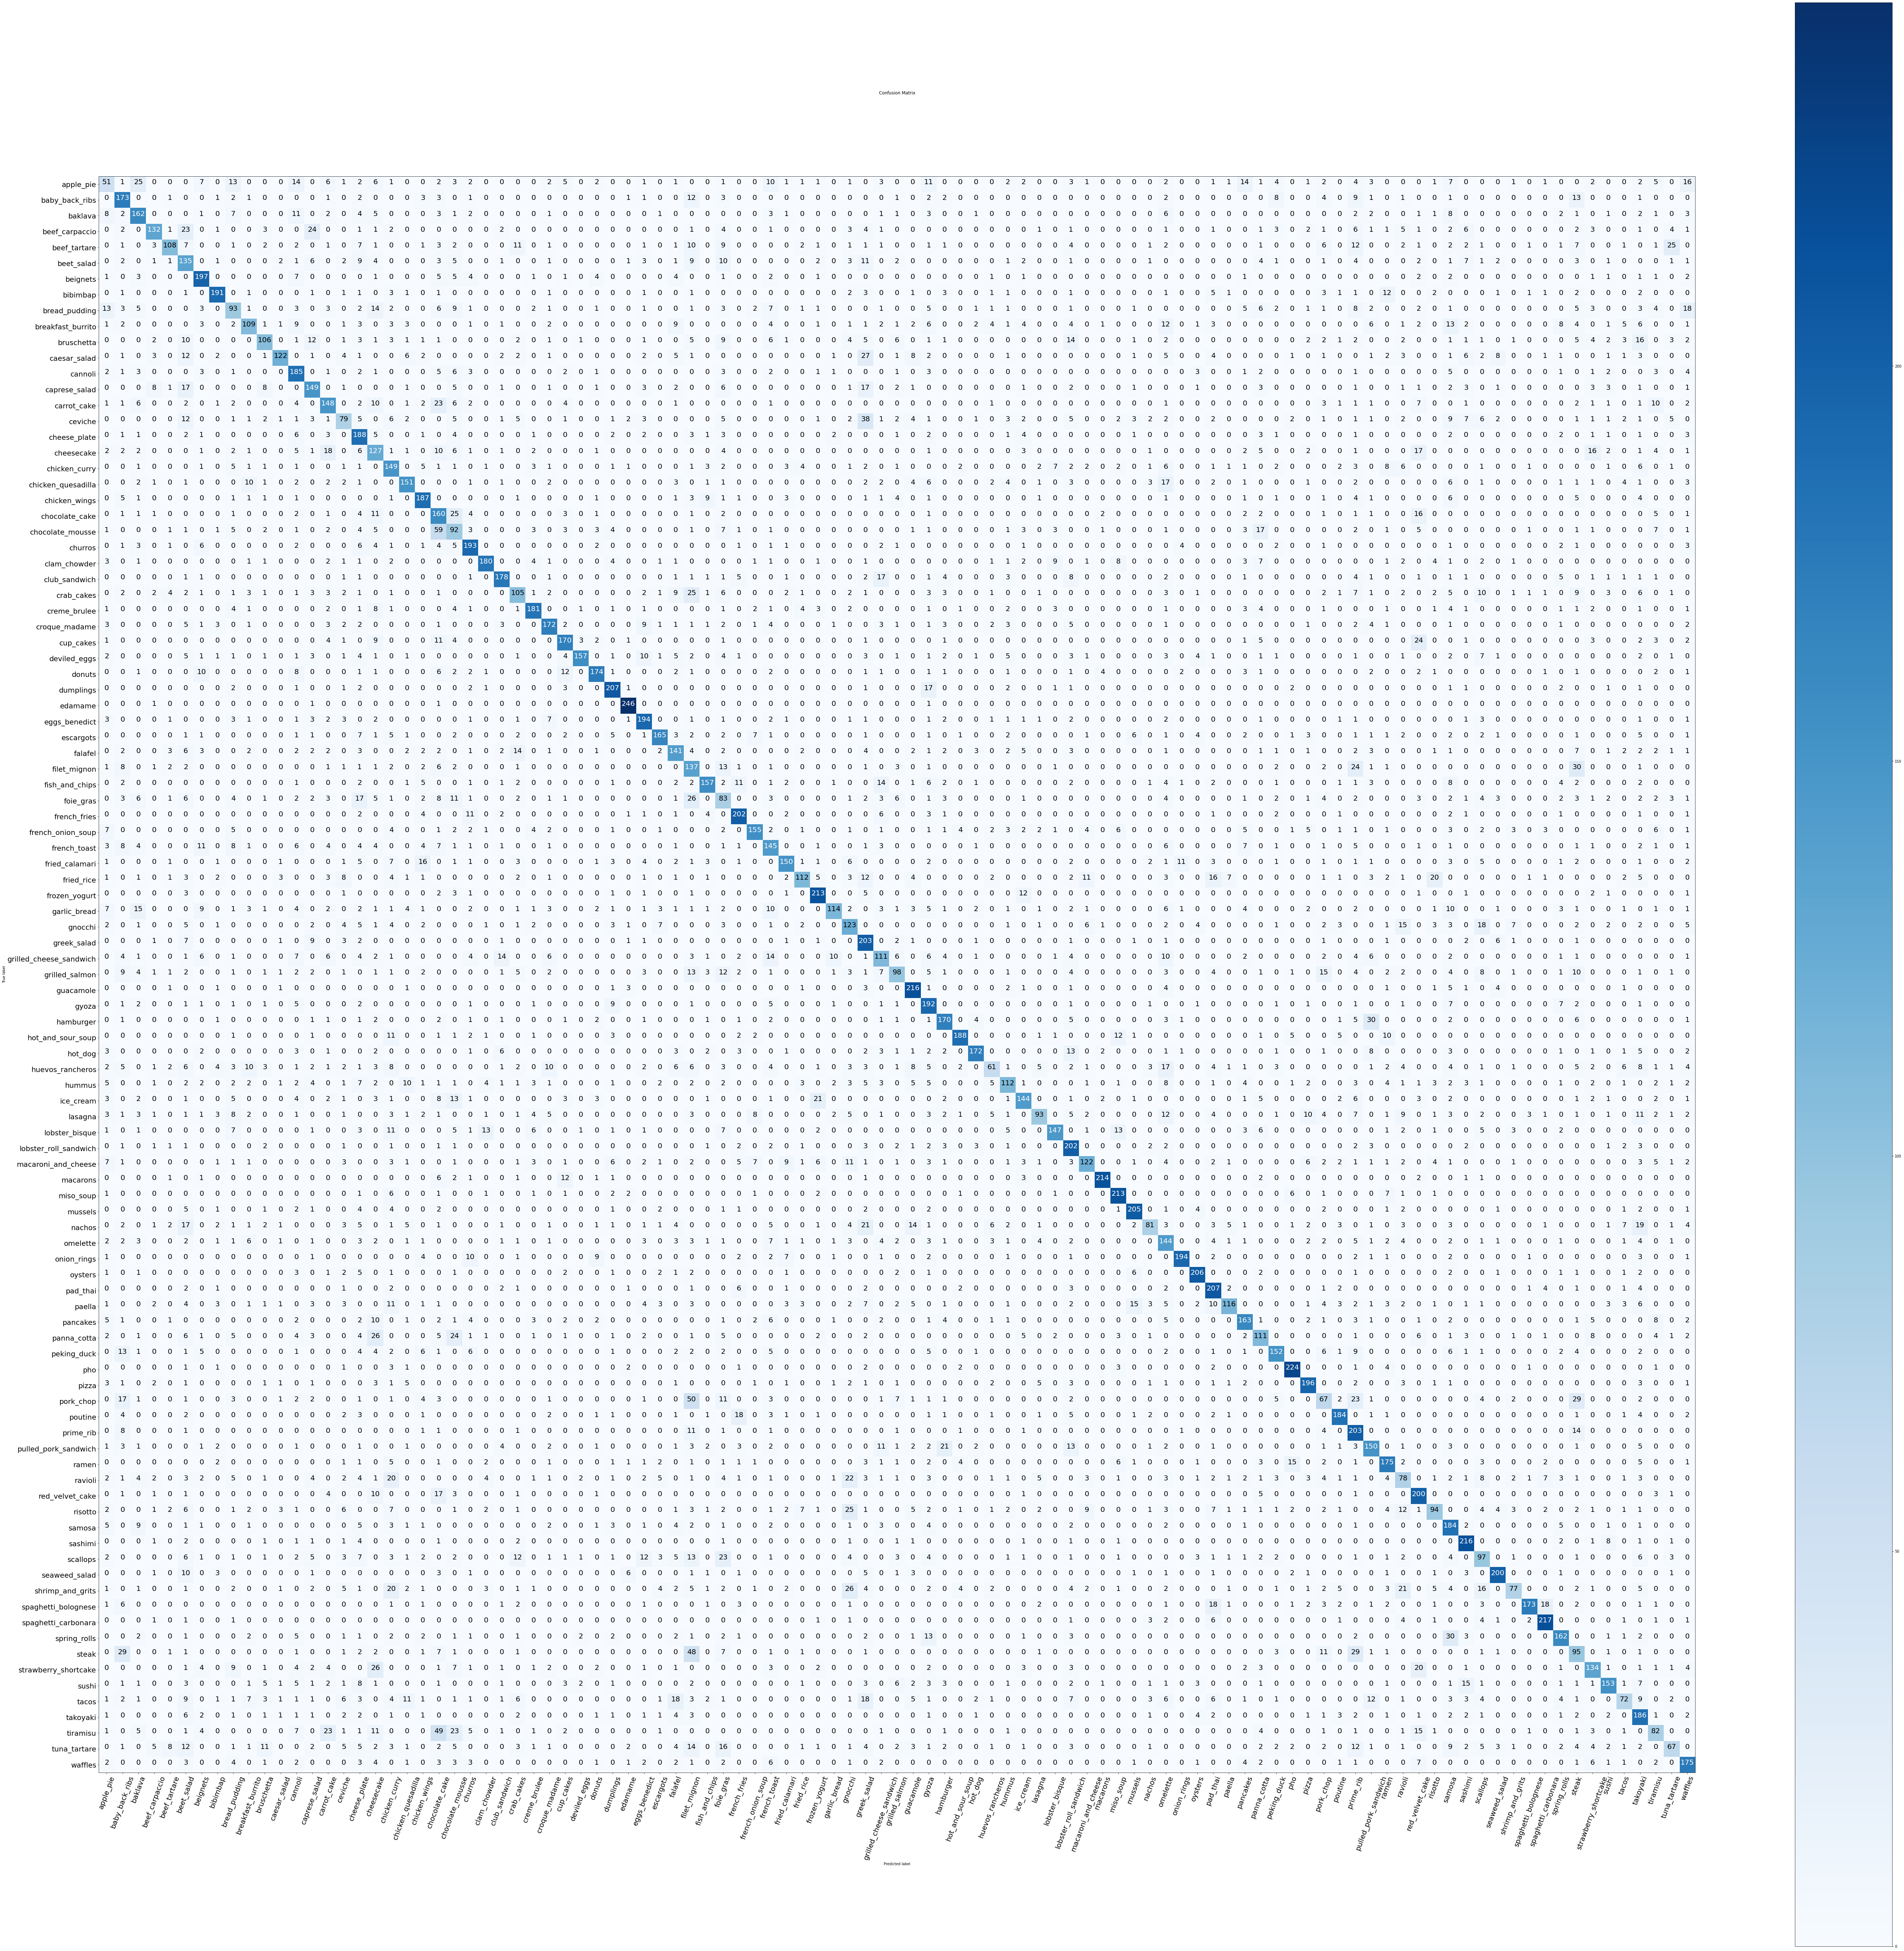

In [ ]:
make_confusion_matrix(y_true=y_labels, 
                      y_pred=pred_classes, 
                      classes=test_data.class_names, 
                      figsize=(100, 100), 
                      text_size=20, 
                      savefig=True)

## Let's keep the evaluation train going, time for a classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels, y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [ ]:
test_data.class_names[30]

'deviled_eggs'

In [ ]:
classification_report_dict = classification_report(y_true=y_labels, y_pred=pred_classes, output_dict=True)

In [ ]:
classification_report_dict

In [ ]:
class_f1_scores = {}
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break 
  else: 
    # Add the values to the class_f1_scores dict
    class_f1_scores[test_data.class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
len(class_f1_scores)

101

In [ ]:
import pandas as pd
f1_scores_df = pd.DataFrame({"class_name": list(class_f1_scores.keys()), "f1_score": list(class_f1_scores.values())}).sort_values("f1_score", ascending=False)
f1_scores_df

class_name  f1_score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
56     huevos_rancheros  0.339833
22     chocolate_mousse  0.329159
77            pork_chop  0.308756
39            foie_gras  0.297491
0             apple_pie  0.240566

[101 rows x 2 columns]

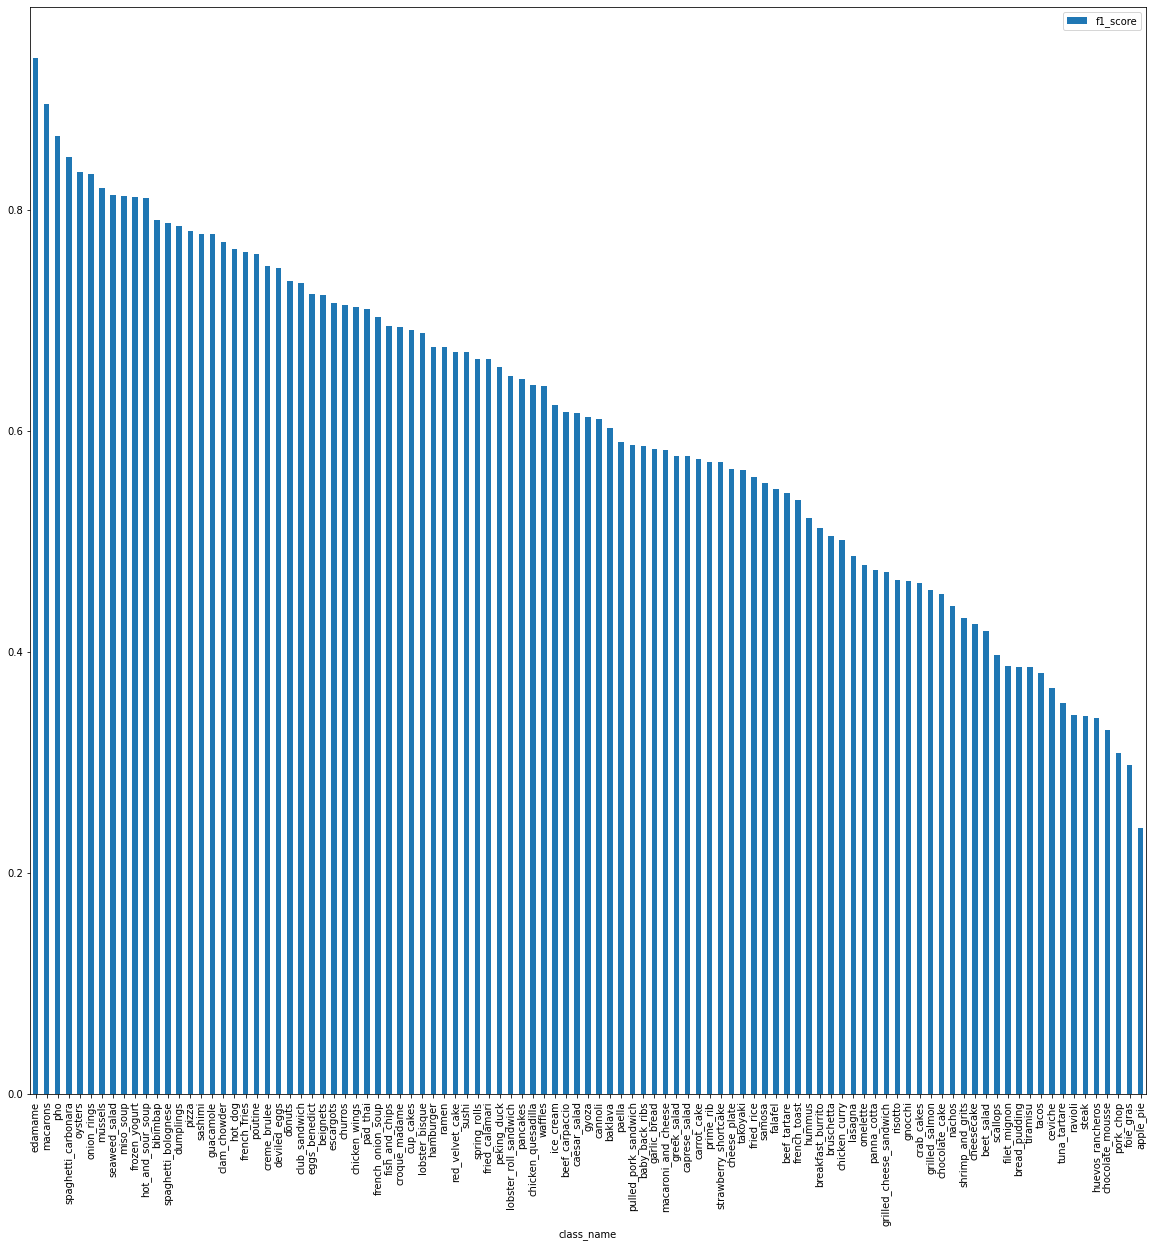

In [ ]:
f1_scores_df.plot.bar("class_name", "f1_score", figsize=(20, 20))

<BarContainer object of 101 artists>

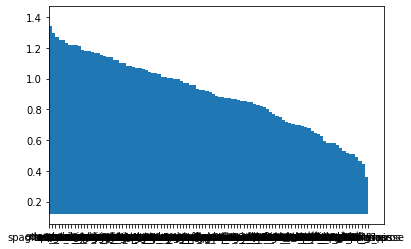

In [ ]:
import matplotlib.pyplot as plt 
plt.figure()
plt.barh(y=f1_scores_df["f1_score"], width=f1_scores_df["class_name"], height=f1_scores_df["f1_score"])


In [ ]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads a image, turns it into tensor, scales and changes the shape of the image
  
  Args:
    filename
    img_shape
    scale
    """
  # Read the target image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize our image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/No
  if scale:
    return img/255.
  
  return img


In [ ]:
class_names = test_data.class_names

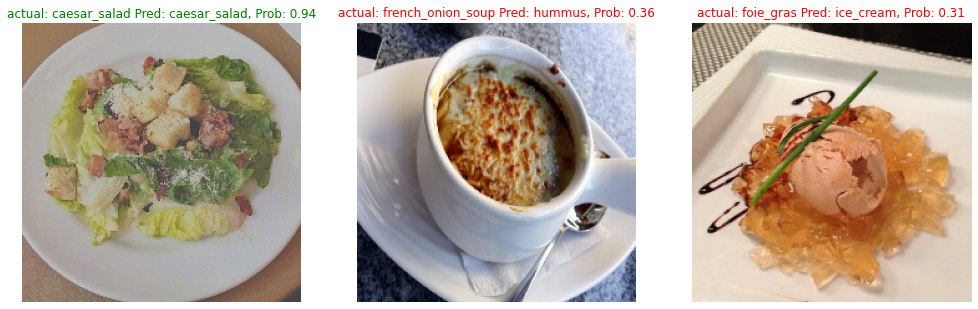

In [ ]:
# Make prediction on series of random images
import os 
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random class
  class_name = random.choice(class_names)
  random_image = random.choice(os.listdir(f"{test_dir}{class_name}"))
  filepath = f"{test_dir}{class_name}/{random_image}"

  # Load the image and make prediction 
  img = load_and_prep_image(filepath, scale=False)
  img_expanded = tf.expand_dims(img, axis=0)
  # print(img_expanded.shape)
  pred_prob = d_model.predict(img_expanded)
  pred_class = class_names[pred_prob.argmax()]
  # print(pred_class)
  # Plot the images
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)

  if class_name == pred_class:
    # Change the title text color to green
    title_color = "g"
  else:
    title_color = "r"
  
  plt.title(f"actual: {class_name} Pred: {pred_class}, Prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False)


## Finding the most wrong prediction

In [ ]:
import pandas as pd

In [ ]:
all_files = tf.data.Dataset.list_files(test_dir)

In [ ]:
# Get all the image file paths in the test dataset 
filepaths = []

for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
  filepaths.append(filepath.numpy())

filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
# 2. Create a dataframe of different paramentrs for each of our test images
pred_df = pd.DataFrame({
    "img_path": filepaths,
    "y_true": y_labels,
    "y_pred": pred_classes,
    "pred_conf": pred_probs.max(axis=1),
    "y_true_classname": [class_names[i] for i in y_labels],
    "y_pred_classname": [class_names[i] for i in pred_classes],

})
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classname      y_pred_classname  
0       0.847419        apple_pie                 gyoza  
1       0.964017        apple_pie             apple_pie  
2       0.959259        apple_pie             apple_pie  
3       0.658607        apple_pie  pulled_pork_sandwich  
4       0.367901        apple_pie             prime_rib  
...          ...              ...                   ...  
25245   0.972823          waffles               waffles  
25246   0.878028          waffles          cheese_plate  
25247   0.537899          waffles               waffles  
25248   0.501950          waffles  strawberry_shortcake  
25249   0.690629          waffles               waffles  

[25250 rows x 6 columns]

In [ ]:
pred_df[pred_df["y_true_classname"] != pred_df["y_pred_classname"]]

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
5      b'/content/101_food_classes_10_percent/test/ap...       0      61   
6      b'/content/101_food_classes_10_percent/test/ap...       0      29   
...                                                  ...     ...     ...   
25234  b'/content/101_food_classes_10_percent/test/wa...     100      83   
25236  b'/content/101_food_classes_10_percent/test/wa...     100      22   
25243  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   

       pred_conf y_true_classname       y_pred_classname  
0       0.847419        apple_pie                  gyoza  
3       0.658607        apple_pie   pulled_pork_sandwich  
4       0.367901        apple_pie              prime_rib  
5       0.456755        apple_pie  lobster_roll_sandwich  
6       0.611242        apple_pie              cup_cakes  
...          ...              ...                    ...  
25234   0.248724          waffles        red_velvet_cake  
25236   0.603934          waffles       chocolate_mousse  
25243   0.474087          waffles           cheese_plate  
25246   0.878028          waffles           cheese_plate  
25248   0.501950          waffles   strawberry_shortcake  

[9904 rows x 6 columns]

In [ ]:
pred_df[pred_df["y_true_classname"] != pred_df["y_pred_classname"]]["y_true_classname"].value_counts()

apple_pie              199
huevos_rancheros       189
tuna_tartare           183
pork_chop              183
tacos                  178
                      ... 
guacamole               34
sashimi                 34
spaghetti_carbonara     33
pho                     26
edamame                  4
Name: y_true_classname, Length: 101, dtype: int64

In [ ]:
pred_df["pred_correct"] = pred_df["y_true_classname"] == pred_df["y_pred_classname"]

In [ ]:
pred_df.pred_correct.head()

0    False
1     True
2     True
3    False
4    False
Name: pred_correct, dtype: bool

In [ ]:
top_100_wrong = pred_df[pred_df.pred_correct == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
21810  b'/content/101_food_classes_10_percent/test/sc...      87      29   
231    b'/content/101_food_classes_10_percent/test/ap...       0     100   
15359  b'/content/101_food_classes_10_percent/test/lo...      61      53   
23539  b'/content/101_food_classes_10_percent/test/st...      94      83   
21400  b'/content/101_food_classes_10_percent/test/sa...      85      92   
24540  b'/content/101_food_classes_10_percent/test/ti...      98      83   
2511   b'/content/101_food_classes_10_percent/test/br...      10      61   
5574   b'/content/101_food_classes_10_percent/test/ch...      22      21   
17855  b'/content/101_food_classes_10_percent/test/pa...      71      65   
23797  b'/content/101_food_classes_10_percent/test/su...      95      86   
18001  b'/content/101_food_classes_10_percent/test/pa...      72      67   
11642  b'/content/101_food_classes_10_percent/test/ga...      46      10   
10847  b'/content/101_food_classes_10_percent/test/fr...      43      68   
23631  b'/content/101_food_classes_10_percent/test/st...      94      83   
1155   b'/content/101_food_classes_10_percent/test/be...       4       5   
10854  b'/content/101_food_classes_10_percent/test/fr...      43      68   
23904  b'/content/101_food_classes_10_percent/test/su...      95      86   
7316   b'/content/101_food_classes_10_percent/test/cu...      29      83   
13144  b'/content/101_food_classes_10_percent/test/gy...      52      92   
10880  b'/content/101_food_classes_10_percent/test/fr...      43      68   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False  
18001   0.999904               pancakes               omelette         False  
11642   0.999877           garlic_bread             bruschetta         False  
10847   0.999872         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
1155    0.999858           beef_tartare             beet_salad         False  
10854   0.999854         fried_calamari            onion_rings         False  
23904   0.999823                  sushi                sashimi         False  
7316    0.999816              cup_cakes        red_velvet_cake         False  
13144   0.999799                  gyoza           spring_rolls         False  
10880   0.999778         fried_calamari            onion_rings         False

In [ ]:
top_100_wrong["y_true_classname"].value_counts()

apple_pie              199
huevos_rancheros       189
tuna_tartare           183
pork_chop              183
tacos                  178
                      ... 
sashimi                 34
guacamole               34
spaghetti_carbonara     33
pho                     26
edamame                  4
Name: y_true_classname, Length: 101, dtype: int64

In [ ]:
top_9_file_path = top_100_wrong.img_path
top_9_file_path

21810    b'/content/101_food_classes_10_percent/test/sc...
231      b'/content/101_food_classes_10_percent/test/ap...
15359    b'/content/101_food_classes_10_percent/test/lo...
23539    b'/content/101_food_classes_10_percent/test/st...
21400    b'/content/101_food_classes_10_percent/test/sa...
                               ...                        
8763     b'/content/101_food_classes_10_percent/test/es...
2663     b'/content/101_food_classes_10_percent/test/br...
7924     b'/content/101_food_classes_10_percent/test/do...
18586    b'/content/101_food_classes_10_percent/test/pe...
3519     b'/content/101_food_classes_10_percent/test/ca...
Name: img_path, Length: 100, dtype: object

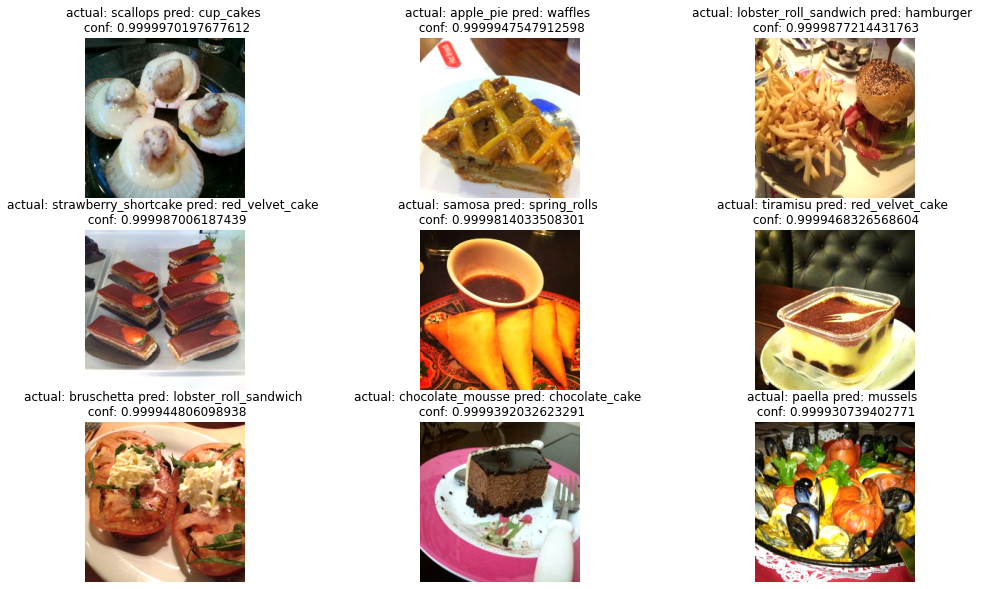

In [ ]:
# Visualise the five most wrong image.
images_to_view = 9
start_index = 0
plt.figure(figsize=(17, 10))
for i in range(images_to_view):
  current_image = top_100_wrong.iloc[i]
  img = load_and_prep_image(filename=current_image["img_path"], scale=False)

  plt.subplot(3, 3, i + 1)
  # plt.figure(figsize=(4, 4))
  plt.imshow(img/225.)
  plt.title(f"actual: {current_image.y_true_classname} pred: {current_image.y_pred_classname} \n conf: {current_image.pred_conf}")
  plt.axis(False)

## Try our model on custom data

In [ ]:
# Get the custom data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

--2022-06-20 12:08:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 142.250.107.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.1s    

2022-06-20 12:08:35 (112 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
unzip_data("custom_food_images.zip")

In [ ]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images/")]
custom_food_images

['custom_food_images/sushi.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/chicken_wings.jpeg']

In [ ]:
a_class_names = test_data.class_names

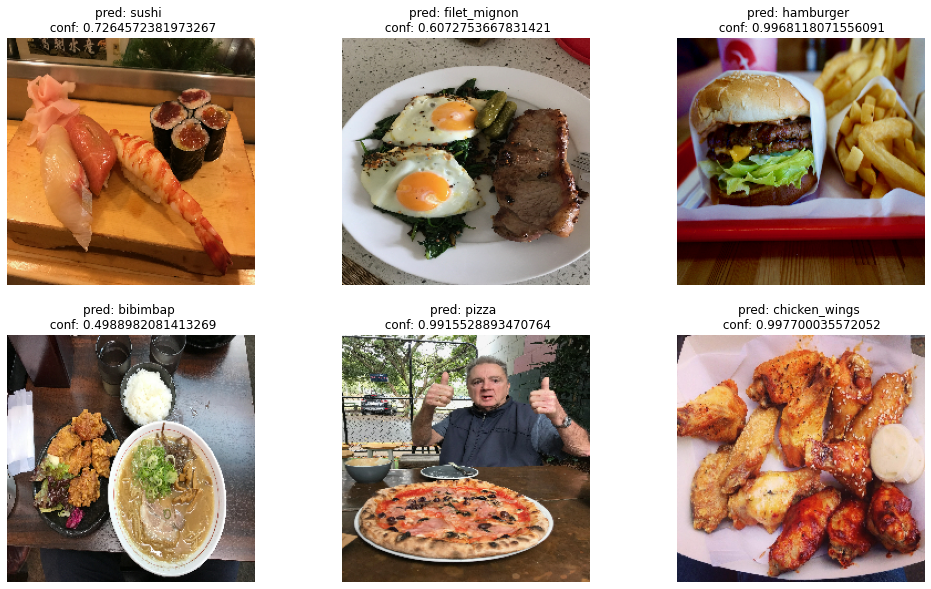

In [ ]:
 # Load and plot cusotm food images

plt.figure(figsize=(17, 10))
for i, food in enumerate(custom_food_images):
  img = load_and_prep_image(filename=food, scale=False)
  pred_prob = d_model.predict(tf.expand_dims(img, axis=0))
  pred_class = a_class_names[pred_prob.argmax()]
  plt.subplot(2, 3, i+1)
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class} \n conf: {pred_prob.max()}")
  plt.axis(False)

In [ ]:
for i, food in enumerate(custom_food_images):
  print(i, food)

0 custom_food_images/sushi.jpeg
1 custom_food_images/steak.jpeg
2 custom_food_images/hamburger.jpeg
3 custom_food_images/ramen.jpeg
4 custom_food_images/pizza-dad.jpeg
5 custom_food_images/chicken_wings.jpeg


In [ ]:
class_names

[20]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster